In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import torch.nn.parameter
import torch.autograd as grad
from torch.nn import functional as F 
import random
from torch.autograd import Function, Variable
from torch.nn import Module, Parameter
import math
import torch.optim
import time
import torchvision
import torchvision.transforms as transforms

/Users/michellezhao/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/michellezhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/michellezhao/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/michellezhao/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/michellezhao/ana

In [2]:
np.random.seed(2)

amp = 100
w = 0.002
b = 20
N = 10000

x = np.arange(N)
data = (amp*np.sin(w*x + b)).astype('float64')
trainX = []
trainY = []
step_size = 5
x_size = 5
y_size = 1
batch_size = 1
for batch in range(batch_size):
    batchX = []
    batchY = []
    for i in range(0, len(data)-15, step_size):
        addx = data[i:i+x_size]
        addy = data[i+x_size:i+x_size+1]
        batchX.append(addx)
        batchY.append(addy)
    trainX.append(batchX)
    trainY.append(batchY)
    
trainX = torch.from_numpy(np.array(trainX))
trainY = torch.from_numpy(np.array(trainY))
x = trainX
y = trainY

In [3]:
sequence_length = 50
input_size = 50
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 1
num_epochs = 2
learning_rate = 0.01

def hard_sigma(a, x):
    temp = torch.div(torch.add(torch.mul(x, a), 1), 2.0)
    output = torch.clamp(temp, min=0, max=1)
    return output

def fbound(z_tilde):
    if z_tilde > 0.5:
        return 1
    return 0

torch.set_default_tensor_type('torch.DoubleTensor')

In [4]:
class LSTMCell(Module):
    '''
    Level 1, Level 2, Level 3
    W_01_bu
    W_11_r
    W_21_td
    '''
    def __init__(self, bottom_size, hidden_size, top_size, a, last_layer):
        super(LSTMCell, self).__init__()
        self.bottom_size = bottom_size
        self.hidden_size = hidden_size
        self.top_size = top_size
        self.last_layer = last_layer
        self.a = a
        self.W_11_r = Parameter(torch.FloatTensor(4 * self.hidden_size + 1, self.hidden_size))
        if not self.last_layer:
            self.W_21_td = Parameter(torch.FloatTensor(4 * self.hidden_size + 1, self.top_size))
        self.W_01_bu = Parameter(torch.FloatTensor(4 * self.hidden_size + 1, self.bottom_size))
        self.bias = Parameter(torch.FloatTensor(4 * self.hidden_size + 1))


    def forward(self, c, h_bottom, h, h_top, z, z_bottom):
        s_recur = torch.mm(self.W_11_r, h).float()
        if not self.last_layer:
            s_bottomup = torch.mm(self.W_01_bu, h_bottom.float())
            s_topdown = torch.mm(self.W_21_td, h_top.float())
        else:
            s_topdown = Variable(torch.zeros(s_recur.size()), requires_grad=False).float()
            s_bottomup = torch.mm(self.W_11_r.long(), h.long())
        s_bottomup = torch.tensor(z_bottom).expand_as(s_bottomup)*s_bottomup
        s_topdown = (torch.tensor(z).expand_as(s_topdown)).long()*(s_topdown.long())

        fslice = s_recur.float() + s_topdown.float() + s_bottomup.float() + self.bias.unsqueeze(1).expand_as(s_recur)

        f_t = F.sigmoid(fslice[0:self.hidden_size, :])  
        i_t = F.sigmoid(fslice[self.hidden_size:self.hidden_size*2, :])
        o_t = F.sigmoid(fslice[self.hidden_size*2:self.hidden_size*3, :])
        u_t = F.tanh(fslice[self.hidden_size*3:self.hidden_size*4, :])
        z_tilde = hard_sigma(self.a, fslice[self.hidden_size*4:self.hidden_size*4+1, :])


        z_new = fbound(z_tilde)

        if z == 1: #(FLUSH)
            c_new = i_t * u_t
            h_new = o_t * F.tanh(c_new)
        elif z_bottom == 0: #(COPY)
            c_new = c
            h_new = h
        else: #(UPDATE)
            c_new = f_t * c + i_t * u_t
            h_new = o_t * F.tanh(c_new)

        return h_new, c_new, z_new, u_t


In [5]:
class HM_LSTM(Module):
    def __init__(self, a, input_size, size_list):
        super(HM_LSTM, self).__init__()
        self.a = a
        self.input_size = input_size
        self.size_list = size_list

        self.cell_1 = LSTMCell(self.input_size, self.size_list[0], self.size_list[1], self.a, False)
        self.cell_2 = LSTMCell(self.size_list[0], self.size_list[1], None, self.a, True)

    def forward(self, inputs, hidden):
        time_steps = 2
        batch_size = 1
        if hidden == None:
            h_t1 = Variable(torch.zeros(self.size_list[0], batch_size).float(), requires_grad=False)
            c_t1 = Variable(torch.zeros(self.size_list[0], batch_size).float(), requires_grad=False)
            z_t1 = Variable(torch.zeros(1, batch_size).float(), requires_grad=False)
            h_t2 = Variable(torch.zeros(self.size_list[1], batch_size).float(), requires_grad=False)
            c_t2 = Variable(torch.zeros(self.size_list[1], batch_size).float(), requires_grad=False)
            z_t2 = Variable(torch.zeros(1, batch_size).float(), requires_grad=False)
        else:
            (h_t1, c_t1, z_t1, h_t2, c_t2, z_t2) = hidden
        z_one = Variable(torch.ones(1, batch_size).float(), requires_grad=False)
        h_1 = []
        h_2 = []
        z_1 = []
        z_2 = []
        
        for t in range(time_steps):
            h_t1, c_t1, z_t1, g_t1 = self.cell_1(c=c_t1, h_bottom=inputs[:, t, :].t(), h=h_t1, h_top=h_t2, z=z_t1, z_bottom=z_one)
            h_t2, c_t2, z_t2, g_t2 = self.cell_2(c=c_t2, h_bottom=h_t1, h=h_t2, h_top=None, z=z_t2, z_bottom=z_t1)  # 0.01s used
            h_1 += [h_t1.t()]
            h_2 += [h_t2.t()]
            z_1 += [torch.tensor(z_t1)]
            z_2 += [torch.tensor(z_t2)]

        hidden = (h_t1, c_t1, z_t1, h_t2, c_t2, z_t2)
        g_t = (g_t1, g_t2)
        return h_t1, c_t1, z_t1, h_t2, c_t2, z_t2, g_t1, g_t2



In [6]:
amp = 100
w = 0.002
b = 0
N = 10000

x = np.arange(N)
data = (amp*np.sin(w*x + b)).astype('float64')
trainX = []
trainY = []
step_size = 15
x_size = 5
y_size = 1
batch_size = 1
for batch in range(batch_size):
    batchX = []
    batchY = []
    for i in range(0, len(data)-15, step_size):
        addx = data[i:i+x_size]
        addy = data[i+x_size:i+x_size+1]
        batchX.append(addx)
        batchY.append(addy)
    trainX.append(batchX)
    trainY.append(batchY)
    
trainX = torch.from_numpy(np.array(trainX))
trainY = torch.from_numpy(np.array(trainY))


x = trainX
y = trainY


nb_steps = 20

class LSTM(nn.Module): 
    def __init__(self, size_list): 

        nn.Module.__init__(self)
        self.size_list = size_list
        self.lstm = HM_LSTM(0.5, 5, size_list)
        self.linear = nn.Linear(666, 666, bias = False)
        self.relu = nn.ReLU()
        self.loss = nn.MSELoss()

    def forward(self,x): 
        hidden = self.init_hidden(1)
        h_t1, c_t1, z_t1, h_t2, c_t2, z_t2, g_t1, g_t2 = self.lstm(x, hidden)
        h = torch.cat((h_t1, h_t2),1)
        lin = self.linear(h.t().double())
        g = []
        g.append(g_t1.detach().numpy())
        g.append(g_t2.detach().numpy())
        g = torch.from_numpy(np.array(g)).squeeze(2)
        gh1 = g[0].float()*lin[0].float()
        gh2 = g[1].float()*lin[1].float()
        h_e = self.relu(gh1+gh2)    
        return h_e

    
    def init_hidden(self, batch_size):
        h_t1 = Variable(torch.zeros(self.size_list[0], batch_size).float(), requires_grad=True)
        c_t1 = Variable(torch.zeros(self.size_list[0], batch_size).float(), requires_grad=True)
        z_t1 = Variable(torch.zeros(1, batch_size).float(), requires_grad=True)
        h_t2 = Variable(torch.zeros(self.size_list[1], batch_size).float(), requires_grad=True)
        c_t2 = Variable(torch.zeros(self.size_list[1], batch_size).float(), requires_grad=True)
        z_t2 = Variable(torch.zeros(1, batch_size).float(), requires_grad=True)
        hidden = (h_t1, c_t1, z_t1, h_t2, c_t2, z_t2)
        return hidden

rnn = LSTM([666, 666])
epochs = 1000
batch_size = 1
criterion = nn.MSELoss()
mean_loss = 0. 
optimizer = optim.Adam(rnn.parameters(), 1e-3)
for epoch in range(1,epochs+1): 
    optimizer.zero_grad()
    pred = rnn(x)
    loss = criterion((pred).float(), (y.squeeze(0).squeeze(1)).float())
    loss.backward()
    optimizer = optim.Adam(rnn.parameters(), 1e-3)
    optimizer.step()
    mean_loss += loss.item()
    if epoch%100 == 0: 
        print('Epoch: {} | Loss: {:.6f}'.format(epoch, mean_loss))
        mean_loss = 0
        


/Users/michellezhao/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/michellezhao/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 100 | Loss: 410825.592773
Epoch: 200 | Loss: 338655.040527
Epoch: 300 | Loss: 334523.950439
Epoch: 400 | Loss: 334522.368408
Epoch: 500 | Loss: 334522.233887
Epoch: 600 | Loss: 334522.136963
Epoch: 700 | Loss: 334522.063721
Epoch: 800 | Loss: 334522.004395
Epoch: 900 | Loss: 334521.957275
Epoch: 1000 | Loss: 334521.920898


torch.Size([666])
torch.Size([1, 666, 1])


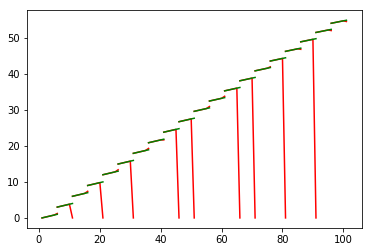

In [7]:
ss = 5
print(pred.shape)
print(y.shape)

new_pred = pred.detach().numpy()
new_trainY = y.squeeze(0).squeeze(1).detach().numpy()

start = 1
for i in range(0,20):
    plt_x = range(start, start+ss+1)
    start = start+ss
    plt_y = np.append(trainX[0][i],new_trainY[i])
    plt_y2 = np.append(trainX[0][i], new_pred[i])

    plt.plot(plt_x,plt_y2,'r')
    plt.plot(plt_x,plt_y,'g')
    
    
plt.show()

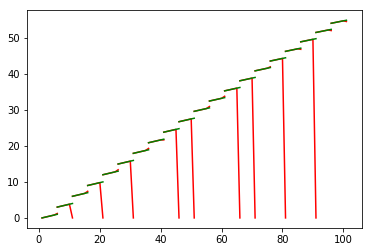

In [8]:
ss = 5
new_pred = pred.detach().numpy()
new_trainY = y.squeeze(0).squeeze(1).detach().numpy()

start = 1
for i in range(0,20):
    plt_x = range(start, start+ss+1)
    start = start+ss
    plt_y = np.append(trainX[0][i],new_trainY[i])
    plt_y2 = np.append(trainX[0][i], new_pred[i])

    plt.plot(plt_x,plt_y2,'r')
    plt.plot(plt_x,plt_y,'g')
    
    
plt.show()

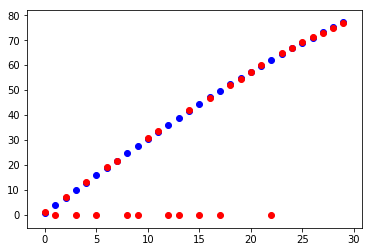

PRED [ 1.2339017  0.         7.380474   0.        13.348594   0.
 19.268942  21.627384   0.         0.        30.884674  33.726414
  0.         0.        41.889458   0.        46.74227    0.
 51.938828  54.456192  57.077065  60.06893    0.        64.73813
 66.89106   69.233406  71.31949   72.77197   74.90458   76.82114  ]
Y [ 0.99998333  3.99893342  6.99428473  9.98334166 12.96341426 15.93182066
 18.8858895  21.82296231 24.74039593 27.63556486 30.50586364 33.34870921
 36.1615432  38.94183423 41.68708024 44.3948107  47.06258882 49.68801378
 52.26872289 54.80239368 57.28674601 59.71954414 62.0985987  64.42176872
 66.6869635  68.89214451 71.03532724 73.11458297 75.12804051 77.07388789]


In [9]:
new_pred = pred.detach().numpy()
new_trainY = y.squeeze(0).squeeze(1).detach().numpy()
plt.scatter(range(len(new_trainY[:30])), new_trainY[:30], c='b')
plt.scatter(range(len(new_pred[:30])), new_pred[:30], c='r')

plt.show()

print("PRED", new_pred[:30].transpose())
print("Y", new_trainY[:30].transpose())

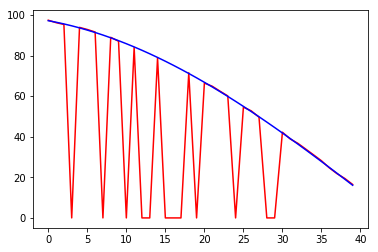

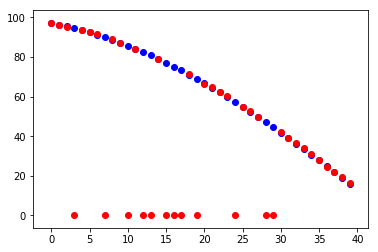

PRED [ 1.2339017  0.         7.380474   0.        13.348594   0.
 19.268942  21.627384   0.         0.        30.884674  33.726414
  0.         0.        41.889458   0.        46.74227    0.
 51.938828  54.456192  57.077065  60.06893    0.        64.73813
 66.89106   69.233406  71.31949   72.77197   74.90458   76.82114  ]
Y [ 0.99998333  3.99893342  6.99428473  9.98334166 12.96341426 15.93182066
 18.8858895  21.82296231 24.74039593 27.63556486 30.50586364 33.34870921
 36.1615432  38.94183423 41.68708024 44.3948107  47.06258882 49.68801378
 52.26872289 54.80239368 57.28674601 59.71954414 62.0985987  64.42176872
 66.6869635  68.89214451 71.03532724 73.11458297 75.12804051 77.07388789]


In [10]:
new_pred = pred.detach().numpy()
new_trainY = y.squeeze(0).squeeze(1).detach().numpy()

plot_x = range(len(new_pred[60:100]))
plot_y = new_pred[60:100]
plot_y2 = new_trainY[60:100]

points1 = []
points2 = []
for i in range(len(plot_x)):
    points1.append([plot_x[i], plot_y[i]])
    points2.append([plot_x[i], plot_y2[i]])

plt.plot(range(len(new_pred[60:100])), new_pred[60:100], 'r')
plt.plot(range(len(new_trainY[60:100])), new_trainY[60:100], 'b')
plt.show()

plt.scatter(range(len(new_trainY[60:100])), new_trainY[60:100], c='b')
plt.scatter(range(len(new_pred[60:100])), new_pred[60:100], c='r')

plt.show()

print("PRED", new_pred[:30].transpose())
print("Y", new_trainY[:30].transpose())

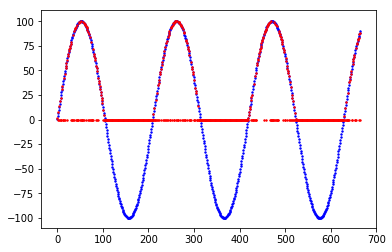

PRED [ 1.2339017  0.         7.380474   0.        13.348594   0.
 19.268942  21.627384   0.         0.        30.884674  33.726414
  0.         0.        41.889458   0.        46.74227    0.
 51.938828  54.456192  57.077065  60.06893    0.        64.73813
 66.89106   69.233406  71.31949   72.77197   74.90458   76.82114  ]
Y [ 0.99998333  3.99893342  6.99428473  9.98334166 12.96341426 15.93182066
 18.8858895  21.82296231 24.74039593 27.63556486 30.50586364 33.34870921
 36.1615432  38.94183423 41.68708024 44.3948107  47.06258882 49.68801378
 52.26872289 54.80239368 57.28674601 59.71954414 62.0985987  64.42176872
 66.6869635  68.89214451 71.03532724 73.11458297 75.12804051 77.07388789]


In [11]:
new_pred = pred.detach().numpy()
new_trainY = y.squeeze(0).squeeze(1).detach().numpy()

plot_x = range(len(new_pred[60:100]))
plot_y = new_pred[60:100]
plot_y2 = new_trainY[60:100]

points1 = []
points2 = []
for i in range(len(plot_x)):
    points1.append([plot_x[i], plot_y[i]])
    points2.append([plot_x[i], plot_y2[i]])

plt.scatter(range(len(new_trainY)), new_trainY, c='b', s=2)
plt.scatter(range(len(new_pred)), new_pred, c='r', s=2)

plt.show()

print("PRED", new_pred[:30].transpose())
print("Y", new_trainY[:30].transpose())

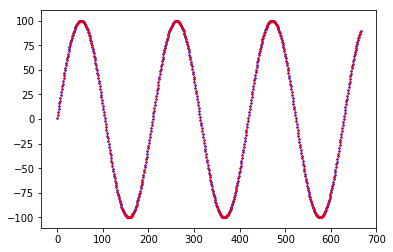

PRED [ 1.2339017  0.         7.380474   0.        13.348594   0.
 19.268942  21.627384   0.         0.        30.884674  33.726414
  0.         0.        41.889458   0.        46.74227    0.
 51.938828  54.456192  57.077065  60.06893    0.        64.73813
 66.89106   69.233406  71.31949   72.77197   74.90458   76.82114  ]
Y [ 0.99998333  3.99893342  6.99428473  9.98334166 12.96341426 15.93182066
 18.8858895  21.82296231 24.74039593 27.63556486 30.50586364 33.34870921
 36.1615432  38.94183423 41.68708024 44.3948107  47.06258882 49.68801378
 52.26872289 54.80239368 57.28674601 59.71954414 62.0985987  64.42176872
 66.6869635  68.89214451 71.03532724 73.11458297 75.12804051 77.07388789]


In [12]:
new_pred = pred.detach().numpy()
new_trainY = y.squeeze(0).squeeze(1).detach().numpy()

plot_x = range(len(new_pred))
plot_y = new_pred
plot_y2 = new_trainY

points1 = []
points2 = []
for i in range(len(plot_x)):
    points1.append([plot_x[i], plot_y[i]])
    points2.append([plot_x[i], plot_y2[i]])

# plt.plot(range(len(new_pred[60:100])), new_pred[60:100], 'r')
# plt.plot(range(len(new_trainY[60:100])), new_trainY[60:100], 'b')
# plt.show()

# plt.scatter(points1, 'r')
# plt.scatter(points2, 'b')
# plt.show()
plt.scatter(range(len(new_trainY)), new_trainY, c='b', s=2)
for i in range(len(plot_x)):
    if plot_y2[i]!=0:
        plt.scatter(plot_x[i], plot_y2[i], c='r', s=1)

plt.show()

print("PRED", new_pred[:30].transpose())
print("Y", new_trainY[:30].transpose())